## IR Analysis of Personas

In [1]:
import pandas as pd
persona_queries = pd.read_csv("drive/MyDrive/ChatGPT/4_personas_topics_1-50.csv")

persona_queries = persona_queries.drop("Unnamed: 0", axis = 1).rename(columns = {"index": "qno", "persona": "user", "topic": "qid", "queries": "query"})
persona_queries = persona_queries[["qno", "user", "qid", "query"]]
uqv = persona_queries
uqv

,qno,user,qid,query
0,1,edith,1,radio waves
1,2,edith,1,brain cancer
2,3,edith,1,incidence brain cancer general population
3,4,edith,1,incidence brain cancer radio towers
4,5,edith,1,incidence brain cancer mobile phones
...,...,...,...,...
1921,6,markus,49,college attendance benefits
1922,7,markus,49,college education job prospects
1923,8,markus,49,college degree advantages
1924,9,markus,49,college education income impact


In [ ]:
!pip install python-terrier

In [ ]:
!pip install ranx

In [ ]:
!pip install repro-eval

In [ ]:
!wget https://th-koeln.sciebo.de/s/Agvx4PoLN3oCkZh/download -O ./drive/MyDrive/ChatGPT/index.tar.xz

In [ ]:
!tar -xf ./drive/MyDrive/ChatGPT/index.tar.xz -C ./drive/MyDrive/ChatGPT/

In [2]:
import os
# valid for google colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import pyterrier as pt
if not pt.started():
    pt.init()
    

from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion
    
dataset = pt.get_dataset('irds:nyt/trec-core-2017')

#needs to be adjusted to own system
index_ref = pt.IndexRef.of("./drive/MyDrive/ChatGPT/nyt")#('./index/nyt') 

qrels = Qrels.from_ir_datasets("nyt/trec-core-2017")

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



Replacing the qid with the correct one matching the qrels data. 

In [3]:
look_up_ids = dataset.get_topics()["qid"].reset_index().rename(columns = {"index":"topic"})
look_up_ids["topic"] = look_up_ids["topic"].astype(float)

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Also replacing special characters within the persona queries, otherwise the following error occurs:

```
JavaException: JVM exception occurred: Failed to process qid 423 'Milosevic's wife nickname' -- Lexical error at line 1, column 10.  Encountered: "\'" (39), after : "" org.terrier.querying.parser.QueryParserException
```

In [4]:
uqv = uqv.merge(look_up_ids, how = "left", left_on = "qid", right_on = "topic").rename(columns = {"qid_y": "qid"}).drop(labels = ["qid_x", "topic"], axis = "columns")
uqv = uqv[["qno", "user", "qid", "query"]]
uqv["query"] = uqv["query"].replace(to_replace = "'", value = "", regex = True)
uqv

,qno,user,qid,query
0,1,edith,310,radio waves
1,2,edith,310,brain cancer
2,3,edith,310,incidence brain cancer general population
3,4,edith,310,incidence brain cancer radio towers
4,5,edith,310,incidence brain cancer mobile phones
...,...,...,...,...
1921,6,markus,690,college attendance benefits
1922,7,markus,690,college education job prospects
1923,8,markus,690,college degree advantages
1924,9,markus,690,college education income impact


The dataset contains more topics than we are currently take into account, therefore we need to slice the dataset to match our topics.

In [5]:
list_qid_personas = uqv["qid"].unique().tolist()
dataset_sliced = dataset.get_topics('title')[dataset.get_topics('title')["qid"].isin(list_qid_personas)]

For some topics, less than 10 queries were produced, they need to be removed from the datasets, otherwise compiling the results is not working

In [6]:
qid_to_remove = []

for i in list_qid_personas:
  for name in uqv["user"].unique():
    if uqv[(uqv["user"] == name) & (uqv["qid"] == i)].shape[0] == 10:
      pass
    else:
      qid_to_remove.append(i)
      print(name, i)

qid_to_remove = set(qid_to_remove)
print(qid_to_remove)

dataset_sliced_revised = dataset_sliced[~dataset_sliced["qid"].isin(qid_to_remove)]
uqv_revised = uqv[~uqv["qid"].isin(qid_to_remove)]

john 400
edith 416
john 416
karen 416
markus 416
edith 677
john 677
{'416', '677', '400'}


In [7]:
bm25 = pt.BatchRetrieve(index_ref, wmodel='BM25')
# slicing of dataset needs to be adjusted depending on the persona queries
baseline = bm25(dataset_sliced_revised)
pt.io.write_results(baseline, 'baseline', format='trec', append=False)
baseline_ranx = Run.from_file('baseline', kind='trec')
baseline_ranx.name = 'BM25'

In [187]:
run_dict = {}

for name in ['edith', 'john', 'karen', 'markus']:

  runs = []

  for i in range(1, 11):

    queries = uqv_revised[(uqv_revised['user'] == name) & (uqv_revised['qno']==i)][['qid', 'query']]

    pt.io.write_results(bm25(queries), 'bm25_'+name, format='trec', append=False)
    runs.append(Run.from_file('bm25_'+name, kind='trec'))

  run_dict[name] = runs

In [8]:
edith_ranx = Run.from_file('bm25_edith', kind='trec')
edith_ranx.name = 'Edith'

john_ranx = Run.from_file('bm25_john', kind='trec')
john_ranx.name = 'John'

karen_ranx = Run.from_file('bm25_karen', kind='trec')
karen_ranx.name = 'Karen'

markus_ranx = Run.from_file('bm25_markus', kind='trec')
markus_ranx.name = 'Markus'

It only works if they have the same ids and also the same number. So if only working with partly results for personas, the qrels must be sliced to the same sample.

In [9]:
import ir_datasets
qrels_dataset = ir_datasets.load("nyt/trec-core-2017").qrels_dict()

qrels_dataset_sub = {}
for id in edith_ranx.get_query_ids():
  qrels_dataset_sub[id] = qrels_dataset[id]

In [10]:
report = compare(
    qrels=Qrels.from_dict(qrels_dataset_sub),
    runs=[baseline_ranx, edith_ranx, john_ranx, karen_ranx, markus_ranx],
    metrics=["ndcg", "map", "precision@10", "bpref"],
    max_p=0.05  
)

report

#    Model    NDCG       MAP        P@10      BPref
---  -------  ---------  ---------  --------  -------
a    BM25     0.414ᵇᶜᵈᵉ  0.184ᵇᶜᵈᵉ  0.454ᶜᵈᵉ  0.261ᶜᵉ
b    Edith    0.325      0.131      0.376     0.239
c    John     0.318      0.118      0.317     0.222
d    Karen    0.317      0.122      0.307     0.230
e    Markus   0.293      0.112      0.304     0.213

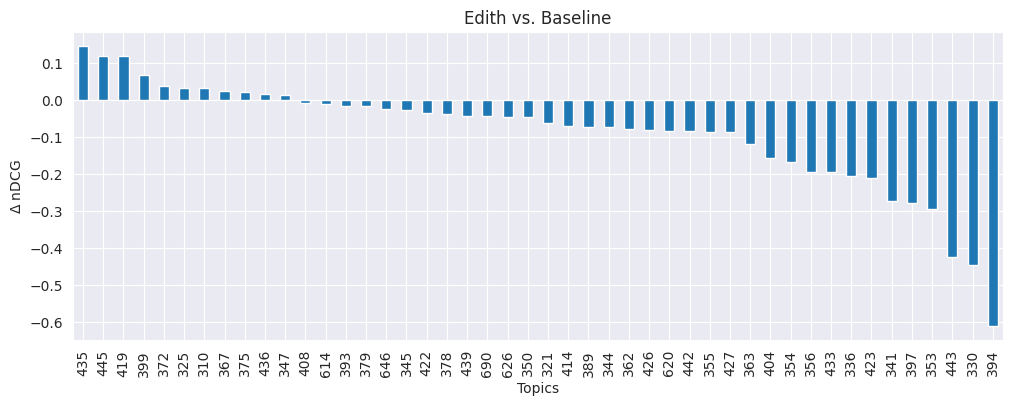

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

delta = pd.DataFrame.from_dict(edith_ranx.scores) - pd.DataFrame.from_dict(baseline_ranx.scores) 
ax = delta['ndcg'].sort_values(ascending=False).plot(figsize=(12,4), kind='bar')
ax.set_xlabel("Topics")
ax.set_ylabel('$\Delta$ nDCG')
plt.title("Edith vs. Baseline")
plt.show()

In [12]:
results_df = pd.DataFrame()

for name in ['edith', 'john', 'karen', 'markus']:
  df_temp_1 = pd.DataFrame.from_dict(eval(name + "_ranx.scores")) - pd.DataFrame.from_dict(baseline_ranx.scores)
  df_temp_1 = df_temp_1.reset_index(names = "qid")
  df_temp_2 = pd.DataFrame({"name": [name]})

  df_temp = df_temp_1.join(df_temp_2, how = "cross")
  results_df = pd.concat([results_df, df_temp], axis = "index")

results_df

,qid,ndcg,map,precision@10,bpref,name
0,310,0.032594,0.024633,0.3,0.002310,edith
1,321,-0.062458,-0.085266,0.0,-0.006780,edith
2,325,0.032756,0.038799,0.2,0.083260,edith
3,330,-0.446091,-0.078958,-0.2,-0.097382,edith
4,336,-0.205252,-0.246066,-0.3,-0.057751,edith
...,...,...,...,...,...,...
41,614,-0.439499,-0.413801,-0.9,-0.435367,markus
42,620,-0.102601,-0.211946,-0.4,-0.131344,markus
43,626,-0.250607,-0.190734,-0.3,-0.065443,markus
44,646,-0.050618,0.021424,0.0,0.090679,markus


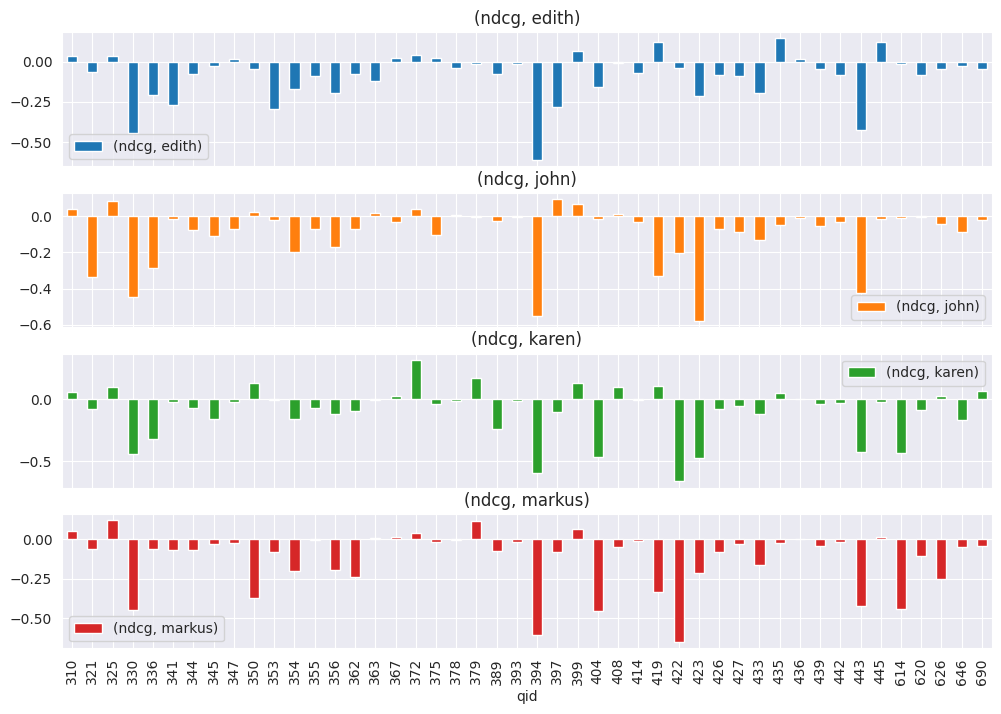

In [14]:
ax = results_df[["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,8), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
plt.show()